# Training: Checkpoints, Logging, and Callbacks


In this notebook we will cover a quickstart training of the Split Delivery Vehicle Routing Problem (SDVRP), with some additional comments along the way. The SDVRP is a variant of the VRP where a vehicle can deliver a part of the demand of a customer and return later to deliver the rest of the demand.




<a href="https://colab.research.google.com/github/ai4co/rl4co/blob/main/examples/2-full-training.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>



## Installation

Uncomment the following line to install the package from PyPI. Remember to choose a GPU runtime for faster training!

> Note: You may need to restart the runtime in Colab after this


In [1]:
!pip install rl4co

## NOTE: to install latest version from Github (may be unstable) install from source instead:
# !pip install git+https://github.com/ai4co/rl4co.git

## Imports

In [1]:
import torch
from lightning.pytorch.callbacks import ModelCheckpoint, RichModelSummary

from rl4co.envs import SDVRPEnv
from rl4co.models.zoo import AttentionModel
from rl4co.utils.trainer import RL4COTrainer

## Main Setup

### Environment, Model and LitModule

In [2]:
# RL4CO env based on TorchRL
env = SDVRPEnv(generator_params=dict(num_loc=20))

# Model: default is AM with REINFORCE and greedy rollout baseline
model = AttentionModel(env,
                       baseline='rollout',
                       train_data_size=100_000, # really small size for demo
                       val_data_size=10_000)

/home/egor/cousework/10.12.25/rl4co_try/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/home/egor/cousework/10.12.25/rl4co_try/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


### Test greedy rollout with untrained model and plot

Tour lengths: ['15.77', '17.44', '17.61']


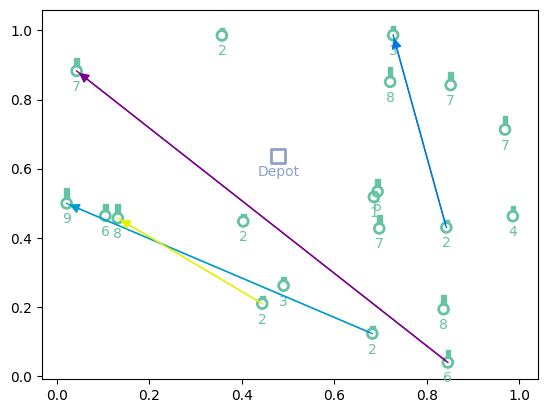

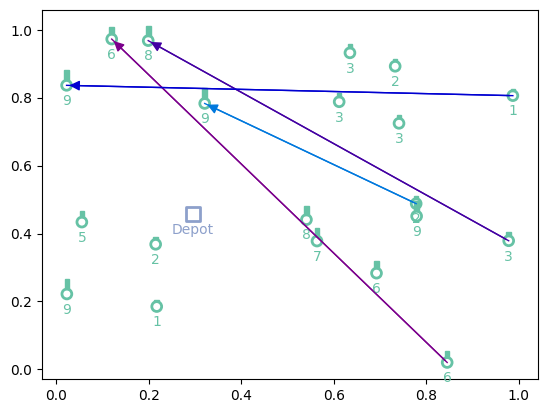

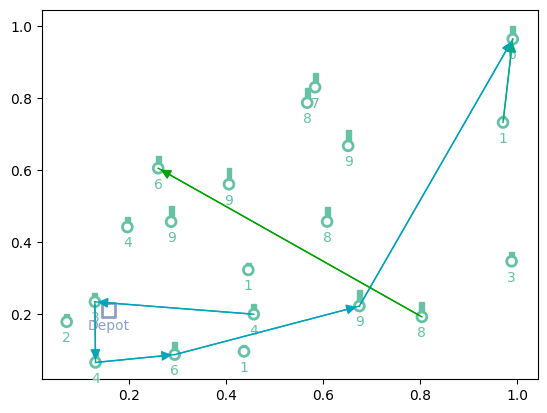

In [3]:
# Greedy rollouts over untrained policy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[3]).to(device)
policy = model.policy.to(device)
out = policy(td_init.clone(), env, phase="test", decode_type="greedy")

# Plotting
print(f"Tour lengths: {[f'{-r.item():.2f}' for r in out['reward']]}")
for td, actions in zip(td_init, out['actions'].cpu()):
    env.render(td, actions)

## Training

### Callbacks 

Here we set up a checkpoint callback to save the best model and another callback for demonstration (nice progress bar). You may check other callbacks [here](https://lightning.ai/docs/pytorch/stable/extensions/callbacks.html)


In [4]:
# Checkpointing callback: save models when validation reward improves
checkpoint_callback = ModelCheckpoint(  dirpath="checkpoints", # save to checkpoints/
                                        filename="epoch_{epoch:03d}",  # save as epoch_XXX.ckpt
                                        save_top_k=1, # save only the best model
                                        save_last=True, # save the last model
                                        monitor="val/reward", # monitor validation reward
                                        mode="max") # maximize validation reward

# Print model summary
rich_model_summary = RichModelSummary(max_depth=3)

# Callbacks list
callbacks = [checkpoint_callback, rich_model_summary]

### Logging

Here we will use Wandb. You may comment below lines if you don't want to use it. You may check other loggers [here](https://lightning.ai/docs/pytorch/stable/extensions/logging.html)

We make sure we're logged into W&B so that our experiments can be associated with our account. You may comment the below line if you don't want to use it.

In [ ]:
# import wandb
# wandb.login()

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

In [5]:
## Comment following two lines if you don't want logging
# from lightning.pytorch.loggers import WandbLogger

# logger = WandbLogger(project="rl4co", name="sdvrp-am")


## Keep below if you don't want logging
logger = None

### Trainer

The RL4CO trainer is a wrapper around PyTorch Lightning's `Trainer` class which adds some functionality and more efficient defaults

The Trainer handles the logging, checkpointing and more for you. 

In [6]:
from rl4co.utils.trainer import RL4COTrainer

trainer = RL4COTrainer(
    max_epochs=2,
    accelerator="gpu",
    devices=1,
    logger=logger,
    callbacks=callbacks,
)

Using 16bit Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


### Fit the model

In [7]:
trainer.fit(model)

wandb: WARNING The anonymous setting has no effect and will be removed in a future version.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:wandb: Enter your choice:wandb: Enter your choice:wandb: Enter your choice:wandb: Enter your choice:wandb: Enter your choice:wandb: WARNING Invalid choice
wandb: Enter your choice:wandb: You chose "Don't visualize my results"
wandb: WARNING `resume` will be ignored since W&B syncing is set to `offline`. Starting a new run with run id q1hb0zvy.


val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/egor/cousework/10.12.25/rl4co_try/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃    ┃ Name                                   ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0  │ env                                    │ SDVRPEnv              │      0 │ train │     0 │
│ 1  │ policy                                 │ AttentionModelPolicy  │  694 K │ train │     0 │
│ 2  │ policy.encoder                         │ AttentionModelEncoder │  595 K │ train │     0 │
│ 3  │ policy.encoder.init_embedding          │ VRPInitEmbedding      │    896 │ train │     0 │
│ 4  │ policy.encoder.net                     │ GraphAttentionNetwork │  594 K │ train │     0 │
│ 5  │ policy.decoder                         │ AttentionModelDecoder │ 98.8 K │ train │     0 │
│ 6  │ policy.decoder.context_embedding       │ VRPContext            │ 16.5 K │ train │     0 │
│ 7  │ policy.decoder.dynamic_embedding       │ SDVRPDynamicEmbedding │    384 │ train │     0 │
│ 8  │ policy.decoder.pointer                 │ PointerAttention      │ 16.4 K │ train │     0 │
│ 9  │ policy.decoder.project_node_embeddings │ Linear                │ 49.2 K │ train │     0 │
│ 10 │ policy.decoder.project_fixed_context   │ Linear                │ 16.4 K │ train │     0 │
│ 11 │ baseline                               │ WarmupBaseline        │  694 K │ train │     0 │
│ 12 │ baseline.baseline                      │ RolloutBaseline       │  694 K │ train │     0 │
│ 13 │ baseline.baseline.policy               │ AttentionModelPolicy  │  694 K │ eval  │     0 │
│ 14 │ baseline.warmup_baseline               │ ExponentialBaseline   │      0 │ train │     0 │
└────┴────────────────────────────────────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 1.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.4 M                                                                                                
Total estimated model params size (MB): 5                                                                          
Modules in train mode: 74                                                                                          
Modules in eval mode: 70                                                                                           
Total FLOPs: 0

Output()

/home/egor/cousework/10.12.25/rl4co_try/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/dat
a_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing 
the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/home/egor/cousework/10.12.25/rl4co_try/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/dat
a_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/home/egor/cousework/10.12.25/rl4co_try/.venv/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:534:
Found 70 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If 
this is intentional, you can ignore this warning.

`Trainer.fit` stopped: `max_epochs=2` reached.


## Testing

### Plotting

Here we plot the solution (greedy rollout) of the trained policy to the initial problem

Tour lengths: ['6.12', '6.48', '8.02']


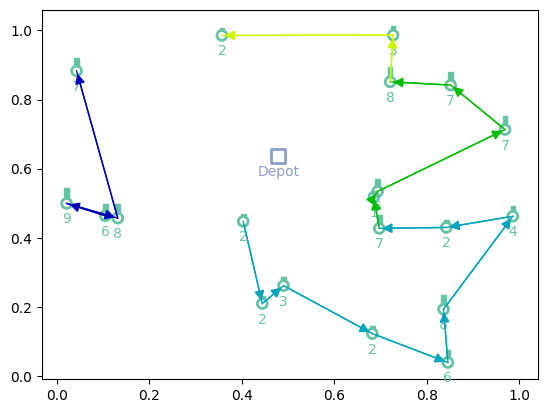

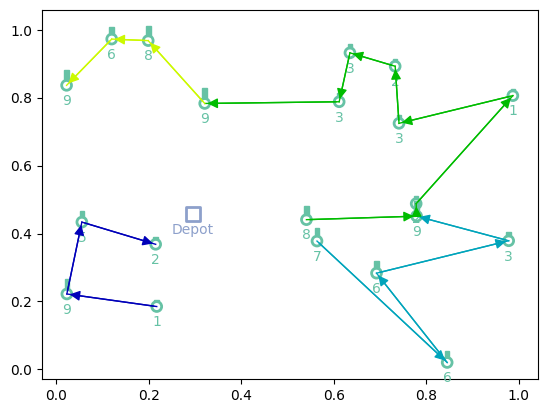

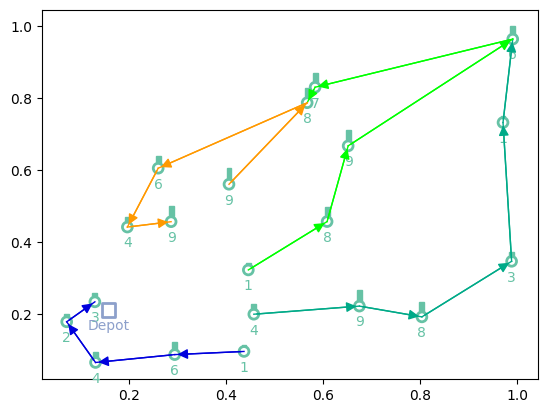

In [8]:
# Greedy rollouts over trained model (same states as previous plot)
policy = model.policy.to(device)
out = policy(td_init.clone(), env, phase="test", decode_type="greedy")

# Plotting
print(f"Tour lengths: {[f'{-r.item():.2f}' for r in out['reward']]}")
for td, actions in zip(td_init, out['actions'].cpu()):
    env.render(td, actions)

### Test function

By default, the dataset is generated or loaded by the environment. You may load a dataset by setting `test_file` during the env config:

```python
env = SDVRPEnv(
    ...
    test_file="path/to/test/file"
)
```
In this case, we test directly on the generated test dataset

In [9]:
trainer.test(model)

val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

/home/egor/cousework/10.12.25/rl4co_try/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test/reward        │    -7.2672858238220215    │
└───────────────────────────┴───────────────────────────┘

[{'test/reward': -7.2672858238220215}]

### Test generalization to new dataset

Here we can load a new dataset (with 50 nodes) and test the trained model on it

In [10]:
# Test generalization to 50 nodes (not going to be great due to few epochs, but hey)
env = SDVRPEnv(generator_params=dict(num_loc=50))

# Generate data (100) and set as test dataset
new_dataset = env.dataset(50)
dataloader = model._dataloader(new_dataset, batch_size=100)

### Plotting generalization


Tour lengths: ['13.87', '10.93', '13.37']


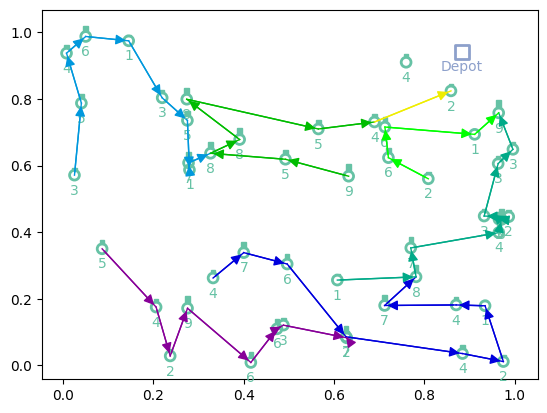

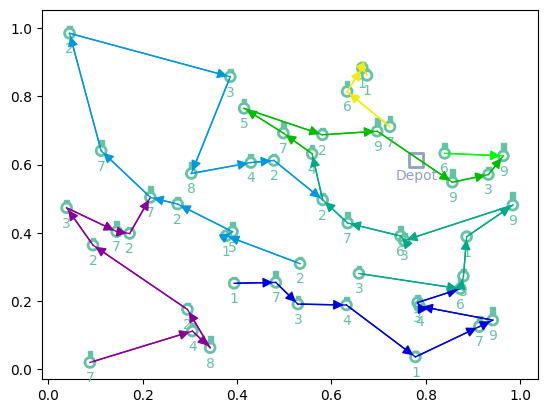

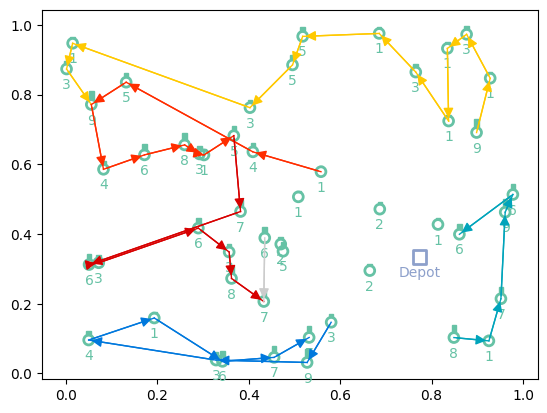

In [11]:
# Greedy rollouts over trained policy (same states as previous plot, with 20 nodes)
init_states = next(iter(dataloader))[:3]
td_init_generalization = env.reset(init_states).to(device)

policy = model.policy.to(device)
out = policy(td_init_generalization.clone(), env, phase="test", decode_type="greedy")

# Plotting
print(f"Tour lengths: {[f'{-r.item():.2f}' for r in out['reward']]}")
for td, actions in zip(td_init_generalization, out['actions'].cpu()):
    env.render(td, actions)

## Loading model

Thanks to PyTorch Lightning,[ we can easily save and load a model to and from a checkpoint](https://lightning.ai/docs/pytorch/stable/common/checkpointing_basic.html)! This is declared in the `Trainer` using the model checkpoint callback. For example, we can load the last model via the `last.ckpt` file located in the folder we specified in the `Trainer`. 

### Checkpointing

In [19]:
# Environment, Model, and Lightning Module (reinstantiate from scratch)
model = AttentionModel(env,
                       baseline="rollout",
                       train_data_size=100_000,
                       test_data_size=10_000,
                       optimizer_kwargs={'lr': 1e-4}
                       )

# Note that by default, Lightning will call checkpoints from newer runs with "-v{version}" suffix
# unless you specify the checkpoint path explicitly
new_model_checkpoint = AttentionModel.load_from_checkpoint("checkpoints/last.ckpt", strict=False, weights_only=False)

/home/egor/cousework/10.12.25/rl4co_try/.venv/lib/python3.12/site-packages/lightning/pytorch/core/saving.py:197: Found keys that are not in the model state dict but in the checkpoint: ['baseline.baseline.policy.encoder.init_embedding.init_embed.weight', 'baseline.baseline.policy.encoder.init_embedding.init_embed.bias', 'baseline.baseline.policy.encoder.init_embedding.init_embed_depot.weight', 'baseline.baseline.policy.encoder.init_embedding.init_embed_depot.bias', 'baseline.baseline.policy.encoder.net.layers.0.0.module.Wqkv.weight', 'baseline.baseline.policy.encoder.net.layers.0.0.module.Wqkv.bias', 'baseline.baseline.policy.encoder.net.layers.0.0.module.out_proj.weight', 'baseline.baseline.policy.encoder.net.layers.0.0.module.out_proj.bias', 'baseline.baseline.policy.encoder.net.layers.0.1.normalizer.weight', 'baseline.baseline.policy.encoder.net.layers.0.1.normalizer.bias', 'baseline.baseline.policy.encoder.net.layers.0.1.normalizer.running_mean', 'baseline.baseline.policy.encoder.ne

Now we can load both the model and environment from the checkpoint!

Tour lengths: ['6.12', '6.48', '8.02']


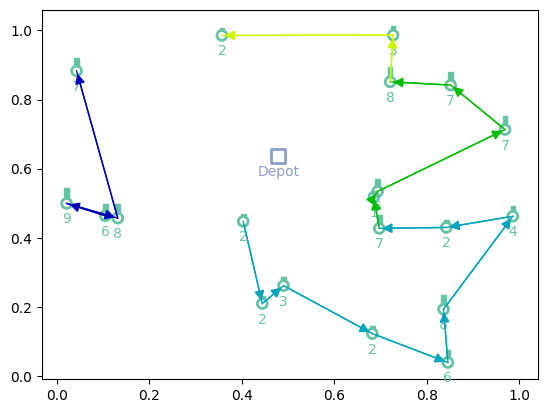

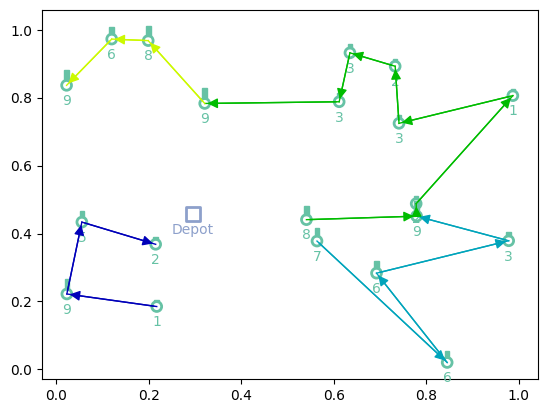

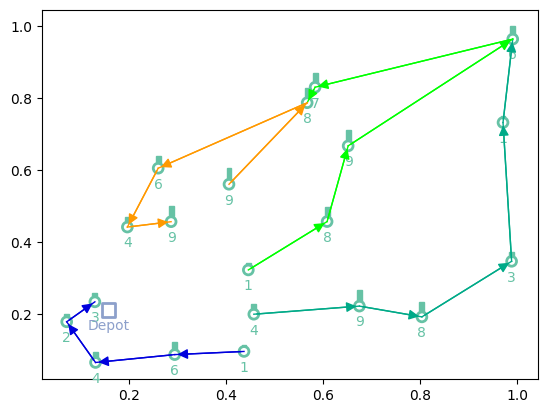

In [20]:
# Greedy rollouts over trained model (same states as previous plot, with 20 nodes)
policy_new = new_model_checkpoint.policy.to(device)
env = new_model_checkpoint.env.to(device)

out = policy_new(td_init.clone(), env, phase="test", decode_type="greedy")

# Plotting
print(f"Tour lengths: {[f'{-r.item():.2f}' for r in out['reward']]}")
for td, actions in zip(td_init, out['actions'].cpu()):
    env.render(td, actions)

## Additional resources

[**Documentation**](https://rl4co.readthedocs.io/) |  [**Getting Started**](https://github.com/ai4co/rl4co/tree/main#getting-started) | [**Usage**](https://github.com/ai4co/rl4co/tree/main#usage) | [**Contributing**](#contributing) | [**Paper**](https://arxiv.org/abs/2306.17100) | [**Citation**](#cite-us)

Have feedback about this notebook? Feel free to contribute by either opening an issue or a pull request! ;)